In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from dateutil.parser import parse
import seaborn as sns

In [2]:
FILE_PATH = 'speaker_attributes.parquet'
speaker_data_original = pd.read_parquet(FILE_PATH, engine = 'pyarrow')
speaker_data = speaker_data_original.copy()
speaker_data.head(2)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None


In [3]:
label_descriptions = pd.read_csv('ProjectDatasets/wikidata_labels_descriptions_quotebank.csv.bz2')
label_descriptions.head(2)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe


In [4]:
def top_qids(data, column_name, max_labels=5):
    
    column_data = data[[column_name]][data[column_name].notnull()]
    column_data_explode = column_data.explode(column_name)
    unique_qids, unique_counts = np.unique(column_data_explode, return_counts=True, return_inverse=False, return_index=False)
    sort_ids = np.argsort(unique_counts)
    unique_qids = unique_qids[sort_ids]
    
    if len(unique_counts) > max_labels:
        qids = unique_qids[-max_labels:]
    else:
        qids = unique_qids[-len(unique_ids):]
        
    return qids, column_data


def get_labels(label_data, qids):
    
    labels = []
    for i in range(len(qids)):
        labels.append(label_data["Label"][label_data.QID==qids[i]].item())
        
    return labels

def count_qids(column_data, qids, label_data = label_descriptions):
    
    counts = np.zeros((len(qids),))

    for i in range(len(column_data)):
        for j in range(len(qids)):
            if qids[j] in column_data.iloc[i].item():
                counts[j]+=1
    
    LABELS = get_labels(label_data, qids)
    x = range(len(qids))

    plt.bar(x, counts, align='center')
    plt.xticks(x, LABELS, rotation = 'vertical')
    plt.show()
    
    return counts

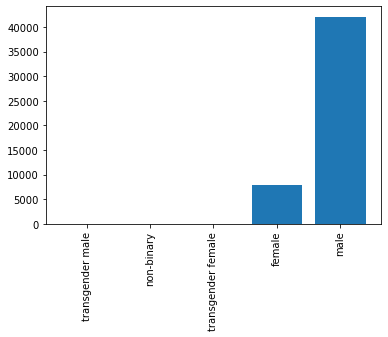

array([4.0000e+00, 2.0000e+00, 1.4000e+01, 7.9070e+03, 4.2074e+04])

In [5]:
# GENDER
qids, column_data = top_qids(data = speaker_data, column_name = 'gender')
count_qids(column_data=column_data[0:50000], qids=qids)

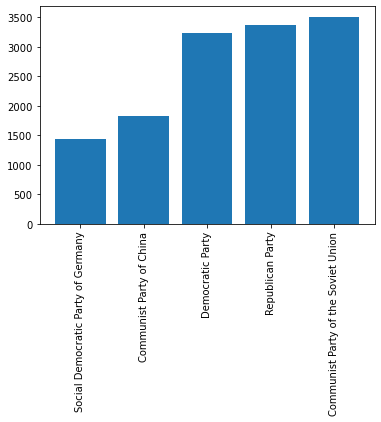

array([1445., 1837., 3238., 3367., 3513.])

In [6]:
# PARTY
qids, column_data = top_qids(data = speaker_data, column_name = 'party')
count_qids(column_data=column_data[0:50000], qids=qids)

In [7]:
speaker_data[['aliases', 'id', 'gender', 'party']].explode('gender')

,aliases,id,gender,party
0,"[Washington, President Washington, G. Washingt...",Q23,Q6581097,[Q327591]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",Q42,Q6581097,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",Q1868,Q6581097,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",Q207,Q6581097,[Q29468]
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",Q297,Q6581097,None
...,...,...,...,...
9055976,[Barker Howard],Q106406560,Q6581097,None
9055977,[Charles Macomber],Q106406571,Q6581097,None
9055978,None,Q106406588,Q6581072,None
9055979,None,Q106406593,Q6581072,None


In [8]:
def year_type(d):
    if d is None:
        year_type = None
    elif d[0][0] == "+":
        year_type = 'AC'
    else:
        year_type = 'BC'
        
    return year_type

def extract_year_of_birth(d):
    if d is None:
        day, month, year = '01','01', '0001'
    else:
        d = d[0]
        day, month, year = d[9:11], d[6:8], d[1:5]
        if int(month) not in range(1,13):
            month = '01'
        if int(day) not in range(1,32):
            day = '01'
        if int(year) == 0:
            year = '0001'
        if (int(day) > 28) & (int(month) == 2):
            day = '28'
        elif (int(day) > 30) & (int(month) in [4,6,9,11]):
            day ='30'
        elif int(day)>31:
            day = '31'
    return day+'-'+month+'-'+year

In [10]:
speaker_data = speaker_data_original.copy()
speaker_data['year_type'] = speaker_data.date_of_birth.apply(lambda d: year_type(d))
speaker_data.date_of_birth = speaker_data.date_of_birth.apply(lambda d: extract_year_of_birth(d))
speaker_data.date_of_birth = speaker_data.date_of_birth.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

In [11]:
speaker_data.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,year_type
0,"[Washington, President Washington, G. Washingt...",1732-02-22 00:00:00,"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443],AC
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",1952-03-11 00:00:00,[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None,AC
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",1868-08-23 00:00:00,[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None,AC
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",1946-07-06 00:00:00,[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]",AC
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",1599-06-06 00:00:00,[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None,AC
